In [ ]:
from __future__ import print_function, division
from builtins import range

In [ ]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from keras.models import Model
from keras.layers import Dense, Embedding, Input
from keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.optimizers import Adam
from sklearn.metrics import roc_auc_score

In [ ]:
import keras.backend as K

In [ ]:
# some configuration
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 50
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 5

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2023-07-27 10:30:12--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-07-27 10:30:12--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-07-27 10:30:13--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [7]:
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [8]:
!ls
!pwd

glove.6B.100d.txt  glove.6B.300d.txt  glove.6B.zip  train.csv
glove.6B.200d.txt  glove.6B.50d.txt   sample_data
/content


In [9]:
print("Loading word vectors......")
word2vec = {}
with open('glove.6B.%sd.txt' % EMBEDDING_DIM) as f:
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype = 'float32')
    word2vec[word] = vec

print('Found %s word vectors' %len(word2vec))

Loading word vectors......
Found 400000 word vectors


In [11]:
print('Loading in comments....')
import csv
train = pd.read_csv('train.csv')
train.head()

Loading in comments....


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [12]:
sentence = train['comment_text'].fillna('DUMMY_VALUE').values  #to convert it to numpy array
possible_labels = train.columns.tolist()[2:]
targets = train[possible_labels].values


In [13]:
print("max sequence length : ", max(len(s) for s in sentence))
print("min sequence length : ", min(len(s) for s in sentence))
s = sorted(len(s) for s in sentence)
print("median sequence length : " ,s[len(s) // 2])

max sequence length :  5000
min sequence length :  6
median sequence length :  205


In [14]:
tokenizer = Tokenizer(num_words = MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentence)
sequences = tokenizer.texts_to_sequences(sentence)

In [15]:
word2idx = tokenizer.word_index
data = pad_sequences(sequences, maxlen = MAX_SEQUENCE_LENGTH)
print('Shape of data tensor', data.shape)



Shape of data tensor (159571, 100)


In [16]:
# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector

Filling pre-trained embeddings...


In [17]:
embedding_layer= Embedding(
    num_words,
    EMBEDDING_DIM,
    weights = [embedding_matrix],
    input_length = MAX_SEQUENCE_LENGTH,
    trainable = False
)

In [18]:
print("Building Model....")
#train a 1d Convnet with global maxpooling

input = Input(shape = (MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input)
x = Bidirectional(LSTM(15,return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(128, activation = 'relu')(x)
output = Dense(len(possible_labels), activation='sigmoid')(x)

Building Model....


In [19]:
model = Model(input, output)
model.compile(loss = 'binary_crossentropy',
              optimizer = Adam(lr = 0.01),
              metrics = ['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [20]:
print('Training model ............')
r = model.fit(
  data,
  targets,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)

Training model ............
Epoch 1/5
998/998 [==============================] - 23s 15ms/step - loss: 0.0666 - accuracy: 0.9785 - val_loss: 0.0562 - val_accuracy: 0.9941
Epoch 2/5
998/998 [==============================] - 12s 12ms/step - loss: 0.0547 - accuracy: 0.9796 - val_loss: 0.0552 - val_accuracy: 0.9941
Epoch 3/5
998/998 [==============================] - 12s 12ms/step - loss: 0.0522 - accuracy: 0.9765 - val_loss: 0.0528 - val_accuracy: 0.8896
Epoch 4/5
998/998 [==============================] - 13s 13ms/step - loss: 0.0504 - accuracy: 0.9758 - val_loss: 0.0531 - val_accuracy: 0.9941
Epoch 5/5
998/998 [==============================] - 12s 12ms/step - loss: 0.0489 - accuracy: 0.9877 - val_loss: 0.0518 - val_accuracy: 0.9940


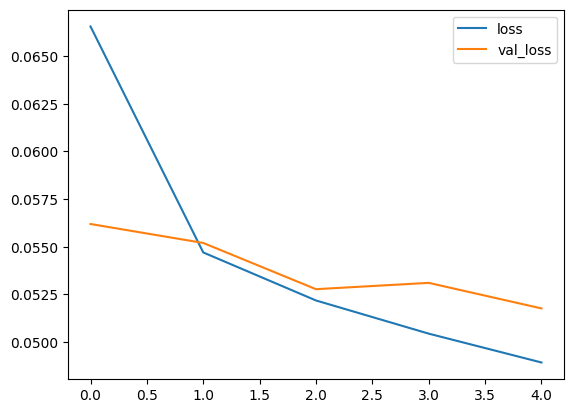

In [21]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

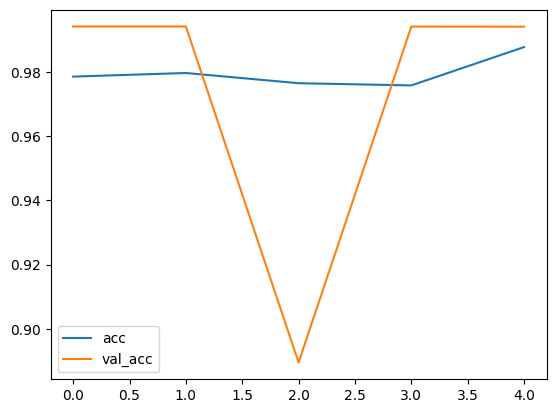

In [22]:
# accuracies
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()

In [23]:
p = model.predict(data)
aucs = []
for j in range(6):
    auc = roc_auc_score(targets[:,j], p[:,j])
    aucs.append(auc)
print(np.mean(aucs))

4987/4987 [==============================] - 24s 5ms/step
0.9818113192869274
